# Analyzing Stock Market Data to Build a Portfolio

## Project Goal

### Analyze share price data from various listings to answer the following questions:

1. What kind of Growth % do we expect from the various listings? <br>
2. How do the Growth % of the different listings correlate to each other? <br>
3. What is the estimated listing share price at a future date (prediction)? <br>
4. What kind of volatility do the listings have? <br>
5. How can we use our analysis to form a balanced investment portfolio? <br>

### Overall Methodology:

1. Import and organize data for the various listings <br>
2. Make observations about the data <br>
3. Use these observations to answer the questions <br>

## References

Share price information obtained from: [Yahoo Finance](https://finance.yahoo.com/) <br>
Yahoo Finance library: [yfinance](https://pypi.org/project/yfinance/) <br>
Robinhood Stocks library: [robin_stocks](http://www.robin-stocks.com/en/latest/functions.html) <br>

## Inputs

### Below are the inputs to perform the analysis

In [1]:
s_list='AM AAPL AMZN FB NVDA NFLX MSFT QCOM PYPL GOOGL TWTR TSLA ZNGA INFY JCI JMIA SSL INTC AMD TSM HRB KO ALTR SQ SPCE INO NIO WKHS SOLO MVIS MRNA JNJ CLX PFE RBLX FCEL CLNE UUUU CARR EH XPEV HON RTX V MA OTIS IDEX GEVO NOK BB SLV PAAS HGSH AG ACB DG DUK SOXX VEGI IEHS MCD IYJ IYR VICE XHS XHB PK IAK SLVP SKYY MSOS ARKG ARKK ARKX ARKQ VXRT SNDL PLTR POTX M WMT KSS NFLX DKS UBER UONE GNUS TOPS DIS ABNB SBUX LYFT GSAT SENS CPRX NBEV PPBT COST SPY NDAQ INDF VWO GOVT BND VT IEF VTI VOO DIA VGK XLK IAU QQQ BETZ COIN GLD GLDG H T NCLH RKT F GM AAL UAL BA BAC JPM AXP GE FUBO SNAP BRK-B QSR XLE XES AMC GRPN GME TTM H MRO OSK TLRY KOSS GPRO VWAGY MMM DMYI AMRS DMLRY BTC-USD ETH-USD DOGE-USD RIOT MARA KO PEP AWK'  # List of "listings" to be analyzed
#s_list='BTC-USD ETH-USD DOGE-USD'
total_investment=7001  # Total investment value in USD
#start='11/27/2020'  # Start date of interest
start='5w'
end='07/01/2020'  # End date of interest
datetime_query=['12/28/2021'] # Datetime query values (for prediction)
pricetype='Close' # Open, Close, Low, High
reverse_data='Y' # Reverse Data
reverse_weights='N' # Go from lowest weight to highest weight instead of normal highest to lowest
save_port='N' # Save portfolio to csv? 'Y' / 'N'
save_mean='N' # Save mean equity values? 'Y' / 'N'

## Import Libraries

In [2]:
# Python Version
import sys
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]'

In [3]:
#Update python standard libraries install
!pip install --upgrade pip

# library to for array handling
import numpy as np 

# library for dataframes
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Linear Model
import sklearn as sk

# List Functions module
!pip install listfun
from listfun import Listoper as lst

# Math Module
import math as m

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# Machine-Learning and analysis modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

! pip install expsolver;
from expsolver import Solver as solve

# Module to handle XML and HTML 
! pip install lxml;

#Finance information import (Link in "Yahoo Finance" Markdown Cell in the "References" Section)
!pip install yfinance;
import yfinance as yf;

#Robinhood stocks functions
!pip install robin_stocks;
import robin_stocks as r;

print('Libraries imported.')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(

Libraries imported.


## Import Data into DataFrame

In [4]:
# Sample interval = 1 day
sample_interval ='1d'

In [5]:
end=pd.to_datetime(end)
if len(start)<=4:
    start=end-pd.to_timedelta(start)
else:
    start=pd.to_datetime(start)
print('Start: {}, End: {}'.format(start,end))

Start: 2020-05-27 00:00:00, End: 2020-07-01 00:00:00


In [6]:
# Calculate number of days
num_days=m.floor(pd.to_timedelta(end-start).total_seconds()/(24*3600))
num_days

35

In [7]:
smooth_window=m.floor(num_days/7)
if smooth_window<1:
    smooth_window=1
#sample_interval='{}d'.format(sample_interval)
smooth_window=1;
print(smooth_window)

1


### Create basic dataframe "df_info" containing all the available stocks information

In [8]:
# Create list of stock names as specified by the User
s_list=s_list.split(' ')
s_list=list(set(s_list))

In [9]:
# Initialize Basic Dataframe as empty
df_info=pd.DataFrame() 

# Add Shares information for List of stock names
for item in s_list:
    try:
        data=yf.Ticker(item)
        df_data=data.history(start=start ,end=end )
        df_data=df_data.reset_index()
        df_data['Name']=pd.DataFrame([item for i in range(0,len(df_data))])
    except:
        print(item)
        continue
    df_info=pd.concat([df_info,df_data])
### Display Initial basic information ####
df_info.head()

- RBLX: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
RBLX
- RKT: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
RKT
- XPEV: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
XPEV
- MSOS: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
MSOS
- PLTR: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
PLTR
- COIN: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
COIN
- ARKX: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
ARKX
- INDF: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
INDF
- DMYI: No data found, symbol may be delisted
DMYI
- ABNB: Data doesn't exist for startDate = 1590537600, endDate = 1593561600
ABNB


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name
0,2020-05-27,159.419998,161.339996,159.199997,161.179993,13063500,0.0,0.0,GLD
1,2020-05-28,162.119995,162.460007,160.899994,161.720001,9758500,0.0,0.0,GLD
2,2020-05-29,162.580002,163.399994,162.320007,162.910004,12581800,0.0,0.0,GLD
3,2020-06-01,162.919998,163.740005,162.389999,163.660004,8140200,0.0,0.0,GLD
4,2020-06-02,163.889999,164.080002,161.860001,162.600006,10388900,0.0,0.0,GLD


In [10]:
# Reverse?#
if reverse_data=='Y':
    df_info=df_info[::-1];
# Display basic information
df_info.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name
24,2020-06-30,12.399986,12.957937,12.226829,12.880979,203500,0.0,0.0,SLVP
23,2020-06-29,12.351886,12.351886,12.159489,12.342266,127700,0.0,0.0,SLVP
22,2020-06-26,12.082532,12.217209,11.755457,12.178730,83500,0.0,0.0,SLVP
21,2020-06-25,11.938234,12.101771,11.822796,12.101771,68900,0.0,0.0,SLVP
20,2020-06-24,12.034433,12.342268,11.784316,11.976713,146900,0.0,0.0,SLVP


In [11]:
# Size of Data:
print('Size of the full dataset is: {} by {}'.format(df_info.shape[0],df_info.shape[1]))

Size of the full dataset is: 3677 by 9


## Exploratory Pre-Processing Analysis

### Create Dataframe (df) of Relevant share Price vs. date, which will be the data looked at in this analysis  

In [12]:
# Create new Dataframe of relevant Share Prices
if reverse_data=='Y':
    datevalues=df_info['Date'].sort_values(ascending=False).drop_duplicates().tolist()
else:
    datevalues=df_info['Date'].sort_values().drop_duplicates().tolist()
    
df=pd.DataFrame(index=datevalues,columns=s_list)
for item in s_list:
    df_item=df_info[df_info['Name']==item]
    for ind in df.index.tolist():
    #df[['Date',item]]=df_info.loc[df_info['Name']==item,['Date',pricetype]]
        try:
            df.loc[ind,item]=df_item.loc[df_item['Date']==ind,pricetype].values[0]
        except:
            pass
    df[item].fillna(method='bfill',inplace=True)
    df[item].fillna(method='ffill',inplace=True)
df['Mean']=df.mean(axis=1)

# Smoothing

df_unsmoothed=df.copy()

df=df.rolling(window=smooth_window).mean()

df.dropna(how='all',axis=1,inplace=True)
df.dropna(how='any',axis=0,inplace=True)

df_price=df.copy()

# Display initial few contents of the Dataset
df.head(10)

,GLD,AMD,M,F,SOLO,BTC-USD,INO,CLX,VWAGY,KO,PK,COST,MARA,GSAT,FUBO,WMT,DOGE-USD,ARKQ,ALTR,VICE,AXP,AG,QCOM,SPCE,GNUS,UUUU,DG,XHB,KSS,IYJ,MMM,GE,GOVT,UAL,BA,POTX,VEGI,BND,OTIS,NCLH,TTM,IDEX,GM,NFLX,AAPL,ARKK,SSL,GOOGL,PPBT,AMRS,PAAS,TSLA,VOO,SOXX,VT,GRPN,BRK-B,LYFT,IAU,IYR,DIS,NBEV,DIA,NVDA,QQQ,SENS,VWO,SQ,IEHS,IAK,VGK,FCEL,UONE,BB,AWK,MCD,IEF,SPY,TWTR,GLDG,ETH-USD,NOK,PYPL,WKHS,ACB,XLE,KOSS,FB,PFE,MRO,GEVO,H,INFY,GPRO,RIOT,AM,DKS,MSFT,V,SBUX,INTC,JCI,BETZ,HGSH,CARR,EH,SLV,UBER,JNJ,SKYY,HON,ARKG,JPM,AMZN,TSM,CPRX,BAC,XLK,AMC,QSR,RTX,JMIA,GME,OSK,TOPS,NIO,SNAP,SNDL,HRB,VXRT,DMLRY,ZNGA,VTI,MA,T,MRNA,AAL,MVIS,XHS,NDAQ,DUK,PEP,CLNE,TLRY,XES,SLVP,Mean
2020-07-01,167.369995,52.610001,6.789999,6.018595,2.25,9228.325195,26.950001,210.522949,15.383236,42.632378,9.89,291.600372,0.91,0.33,10.45,116.994621,0.002354,46.531853,39.750000,22.503616,93.054741,9.938423,88.699341,16.340000,2.25,1.51,188.027222,43.482689,20.399696,74.408028,148.542206,54.328278,27.290329,34.610001,183.300003,9.725407,24.292772,85.186790,55.855526,16.430000,6.57,2.01,25.299999,455.040009,90.322250,69.612381,7.71,1418.050049,11.10,4.27,29.923624,215.962006,277.214447,267.354279,72.590652,18.120001,178.509995,33.009998,33.980000,76.011345,111.510002,1.53,250.887451,94.838211,245.967072,0.390,38.007275,104.940002,30.562010,53.098389,47.901592,2.26,20.250000,4.89,125.935104,178.232651,120.144920,301.803894,29.790001,1.74,231.113419,4.40,174.229996,17.389999,12.42,35.105705,1.36,227.070007,29.045668,5.998861,0.79,50.290001,9.376032,4.760,2.22,4.042174,38.515690,200.805893,191.412415,71.663681,57.506172,33.182510,15.069068,1.60,21.867432,10.484,17.010000,31.080000,135.325714,73.850014,140.701782,51.430191,89.498390,2758.820068,55.358570,4.62,22.996893,103.230553,4.29,51.882236,59.285240,5.49,4.34,70.197968,3.50,7.72,23.490000,0.799,13.224133,8.85,9.757897,9.54,153.237015,293.137695,26.613615,64.209999,13.07,1.36,67.854210,117.147583,75.211075,126.685516,2.22,7.11,32.418766,12.880979,155.712261
2020-06-30,167.369995,52.610001,6.789999,6.018595,2.25,9137.993164,26.950001,210.522949,15.383236,42.632378,9.89,291.600372,0.91,0.33,10.45,116.994621,0.002320,46.531853,39.750000,22.503616,93.054741,9.938423,88.699341,16.340000,2.25,1.51,188.027222,43.482689,20.399696,74.408028,148.542206,54.328278,27.290329,34.610001,183.300003,9.725407,24.292772,85.186790,55.855526,16.430000,6.57,2.01,25.299999,455.040009,90.322250,69.612381,7.71,1418.050049,11.10,4.27,29.923624,215.962006,277.214447,267.354279,72.590652,18.120001,178.509995,33.009998,33.980000,76.011345,111.510002,1.53,250.887451,94.838211,245.967072,0.390,38.007275,104.940002,30.562010,53.098389,47.901592,2.26,20.250000,4.89,125.935104,178.232651,120.144920,301.803894,29.790001,1.74,226.315002,4.40,174.229996,17.389999,12.42,35.105705,1.36,227.070007,29.045668,5.998861,0.79,50.290001,9.376032,4.760,2.22,4.042174,38.515690,200.805893,191.412415,71.663681,57.506172,33.182510,15.069068,1.60,21.867432,10.484,17.010000,31.080000,135.325714,73.850014,140.701782,51.430191,89.498390,2758.820068,55.358570,4.62,22.996893,103.230553,4.29,51.882236,59.285240,5.49,4.34,70.197968,3.50,7.72,23.490000,0.799,13.224133,8.85,9.757897,9.54,153.237015,293.137695,26.613615,64.209999,13.07,1.36,67.854210,117.147583,75.211075,126.685516,2.22,7.11,32.418766,12.880979,155.060682
2020-06-29,166.630005,50.279999,6.533400,5.949302,2.56,9190.854492,31.690001,208.805161,15.226314,42.327045,10.13,290.042419,0.89,0.31,10.49,116.291351,0.002313,45.302414,38.790001,22.189310,92.390053,9.409040,86.559906,15.420000,2.34,1.46,187.543610,42.828964,20.291656,73.584061,148.142273,54.089645,27.329330,35.270000,194.490005,9.977246,24.009501,85.099991,55.570644,16.559999,6.71,2.09,25.299999,447.239990,89.574524,67.708801,7.79,1397.170044,12.00,4.18,27.767237,201.869995,273.566193,260.603027,72.124817,19.080000,177.190002,33.060001,33.860001,75.152962,111.519997,1.47,248.980576,91.865089,241.238434,0.400,38.199177,103.680000,29.873991,51.920788,47.920628,2.34,18.030001,4.

### Display basic information about this dataset

In [13]:
# Display basic statistics of the opening prices
# Darker cells denote higher values
df.describe().style.background_gradient(axis=1).format("{:.2f}")

,GLD,AMD,M,F,SOLO,BTC-USD,INO,CLX,VWAGY,KO,PK,COST,MARA,GSAT,FUBO,WMT,DOGE-USD,ARKQ,ALTR,VICE,AXP,AG,QCOM,SPCE,GNUS,UUUU,DG,XHB,KSS,IYJ,MMM,GE,GOVT,UAL,BA,POTX,VEGI,BND,OTIS,NCLH,TTM,IDEX,GM,NFLX,AAPL,ARKK,SSL,GOOGL,PPBT,AMRS,PAAS,TSLA,VOO,SOXX,VT,GRPN,BRK-B,LYFT,IAU,IYR,DIS,NBEV,DIA,NVDA,QQQ,SENS,VWO,SQ,IEHS,IAK,VGK,FCEL,UONE,BB,AWK,MCD,IEF,SPY,TWTR,GLDG,ETH-USD,NOK,PYPL,WKHS,ACB,XLE,KOSS,FB,PFE,MRO,GEVO,H,INFY,GPRO,RIOT,AM,DKS,MSFT,V,SBUX,INTC,JCI,BETZ,HGSH,CARR,EH,SLV,UBER,JNJ,SKYY,HON,ARKG,JPM,AMZN,TSM,CPRX,BAC,XLK,AMC,QSR,RTX,JMIA,GME,OSK,TOPS,NIO,SNAP,SNDL,HRB,VXRT,DMLRY,ZNGA,VTI,MA,T,MRNA,AAL,MVIS,XHS,NDAQ,DUK,PEP,CLNE,TLRY,XES,SLVP,Mean
count,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00
mean,163.15,53.25,7.12,6.25,1.69,9478.13,17.11,200.51,15.64,44.10,11.08,291.78,0.91,0.33,11.28,117.87,0.00,45.19,38.70,22.76,98.60,9.45,84.34,15.91,3.52,1.60,186.27,42.82,21.91,74.45,150.64,56.70,27.17,36.12,181.62,10.72,24.45,84.68,55.27,18.53,6.65,1.32,27.17,435.41,84.66,64.65,7.80,1425.90,6.49,4.16,27.26,188.73,276.65,259.64,72.46,23.61,184.32,34.86,33.15,77.04,117.02,1.62,252.17,90.48,238.12,0.43,37.65,93.26,30.61,53.84,47.91,2.39,11.79,5.06,124.94,182.25,119.59,301.35,32.75,1.23,234.41,4.28,161.10,5.57,13.63,36.80,1.38,230.29,30.68,6.20,1.20,55.43,9.01,4.67,2.34,4.26,36.15,188.81,192.41,74.84,58.53,32.89,15.59,1.40,21.37,11.82,16.51,33.55,138.54,70.97,143.80,46.75,95.24,2588.53,53.33,4.47,24.34,99.63,5.31,52.69,62.97,5.59,4.52,72.77,3.86,6.17,21.17,0.89,15.26,3.61,9.75,9.23,152.65,298.20,27.11,61.67,14.68,1.19,68.35,115.51,80.04,125.49,2.17,8.91,34.90,11.86,155.65
std,2.59,1.56,0.86,0.49,0.39,248.06,6.67,6.46,0.62,1.43,1.34,4.76,0.12,0.02,0.68,2.02,0.00,0.93,1.03,0.54,5.39,0.54,3.81,0.85,1.51,0.09,2.55,1.26,2.50,2.28,4.31,3.90,0.13,5.01,20.84,0.59,0.69,0.28,2.18,2.78,0.52,0.88,1.82,17.13,3.95,3.07,1.38,24.99,2.76,0.45,1.30,14.06,5.51,7.59,1.50,4.28,7.62,2.60,0.53,2.53,4.92,0.12,6.46,2.70,5.27,0.04,1.01,8.45,0.72,2.36,1.20,0.27,12.14,0.31,2.89,5.27,0.66,5.99,2.05,0.18,8.98,0.17,7.71,4.00,0.86,2.27,0.20,6.72,1.79,0.66,0.16,4.94,0.18,0.20,0.22,0.35,1.83,6.66,3.19,3.10,2.02,1.40,0.64,0.43,1.02,0.60,0.26,2.55,3.34,1.74,6.50,2.86,5.46,114.59,2.24,0.17,1.48,2.32,0.63,1.75,3.56,0.67,0.31,4.43,0.74,1.19,1.85,0.09,1.59,2.19,0.50,0.36,3.15,6.74,0.96,3.12,2.79,0.22,2.15,1.78,3.60,1.36,0.10,0.98,3.70,0.44,2.64
min,158.01,50.10,5.94,5.65,1.13,9045.39,11.88,189.60,15.00,41.57,9.50,285.21,0.70,0.30,10.00,115.00,0.00,43.49,36.24,21.94,91.31,8.40,75.38,14.46,1.81,1.43,181.60,40.74,18.44,71.78,144.95,51.54,26.88,28.04,145.85,9.73,23.63,84.21,50.06,15.28,5.71,0.38,24.46,413.44,78.72,60.10,5.09,1362.54,4.49,3.17,25.49,161.16,268.86,241.86,70.23,18.12,175.37,31.26,32.12,73.77,109.10,1.45,243.60,84.71,228.08,0.39,35.08,79.62,29.41,51.14,45.57,2.09,1.25,4.58,117.99,173.66,118.07,292.93,29.05,1.07,208.86,3.91,145.96,2.48,12.36,33.86,1.10,216.08,28.46,5.23,0.79,47.30,8.60,4.27,2.11,3.58,32.36,178.99,187.16,69.70,55.27,30.30,14.37,0.86,19.22,10.48,16.15,29.61,132.61,67.44,134.49,42.00,88.10,2401.10,48.67,4.10,22.42,95.32,4.18,49.98,56.86,4.35,4.06,67.91,3.25,3.83,17.00,0.80,12.50,2.26,8.92,7.99,148.00,286.83,25.60,52.18,10.50,0.88,64.83,

### Create basic Time plot to look at pertinent information

In [14]:
df_info.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name
24,2020-06-30,12.399986,12.957937,12.226829,12.880979,203500,0.0,0.0,SLVP
23,2020-06-29,12.351886,12.351886,12.159489,12.342266,127700,0.0,0.0,SLVP
22,2020-06-26,12.082532,12.217209,11.755457,12.178730,83500,0.0,0.0,SLVP
21,2020-06-25,11.938234,12.101771,11.822796,12.101771,68900,0.0,0.0,SLVP
20,2020-06-24,12.034433,12.342268,11.784316,11.976713,146900,0.0,0.0,SLVP


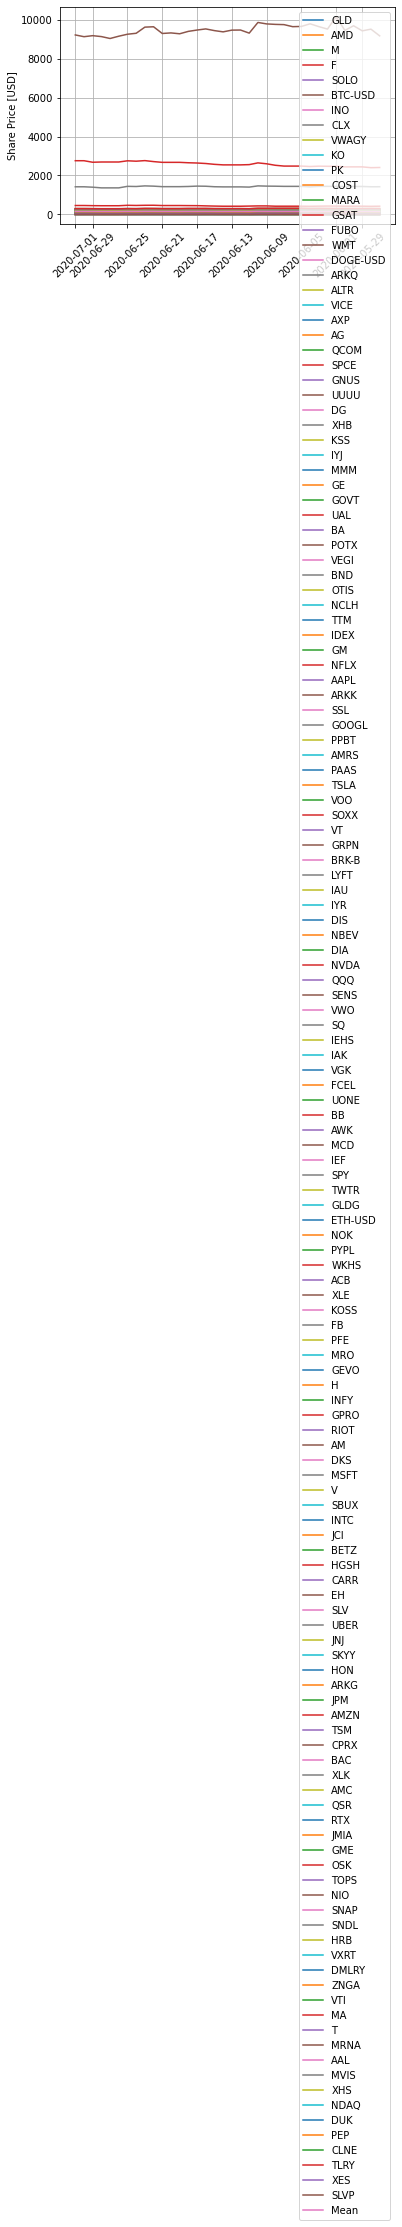

In [15]:
# Plot Open price vs. Time
ax= plt.subplot()
for item in df_price.columns:
    plt.plot(df_price[item])
if reverse_data=='Y':
    ax.invert_xaxis()
    
plt.xticks(rotation=45)
ax.legend(df_price.columns)
plt.ylabel('Share Price [USD]')
ax.grid(True)

## What kind of Growth % do we see with the various listings?

### Normalize the opening price to determine Growth % over the period of interest

Normalize w.r.t. start price (df_start) <br> 
Normalization used: (price-start_price)/start_price*100 to obtain df_norm

In [16]:
# Normalization Function
def df_normalize(df):
    df_strt=df.iloc[0,:]
    df_norm=(df.iloc[:,:]-df_strt)/df_strt*100
    df_strt=pd.DataFrame(df_strt).transpose()
    df_strt.set_axis(['start_price'],axis=0,inplace=True)
    return [df_norm,df_strt]

# Store Normalized values in DataFrame and display results                          
[df_norm,df_start]=df_normalize(df)
df_norm.head()

,GLD,AMD,M,F,SOLO,BTC-USD,INO,CLX,VWAGY,KO,PK,COST,MARA,GSAT,FUBO,WMT,DOGE-USD,ARKQ,ALTR,VICE,AXP,AG,QCOM,SPCE,GNUS,UUUU,DG,XHB,KSS,IYJ,MMM,GE,GOVT,UAL,BA,POTX,VEGI,BND,OTIS,NCLH,TTM,IDEX,GM,NFLX,AAPL,ARKK,SSL,GOOGL,PPBT,AMRS,PAAS,TSLA,VOO,SOXX,VT,GRPN,BRK-B,LYFT,IAU,IYR,DIS,NBEV,DIA,NVDA,QQQ,SENS,VWO,SQ,IEHS,IAK,VGK,FCEL,UONE,BB,AWK,MCD,IEF,SPY,TWTR,GLDG,ETH-USD,NOK,PYPL,WKHS,ACB,XLE,KOSS,FB,PFE,MRO,GEVO,H,INFY,GPRO,RIOT,AM,DKS,MSFT,V,SBUX,INTC,JCI,BETZ,HGSH,CARR,EH,SLV,UBER,JNJ,SKYY,HON,ARKG,JPM,AMZN,TSM,CPRX,BAC,XLK,AMC,QSR,RTX,JMIA,GME,OSK,TOPS,NIO,SNAP,SNDL,HRB,VXRT,DMLRY,ZNGA,VTI,MA,T,MRNA,AAL,MVIS,XHS,NDAQ,DUK,PEP,CLNE,TLRY,XES,SLVP,Mean
2020-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,-0.978856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.444351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.076217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.418450
2020-06-29,-0.442128,-4.428819,-3.779072,-1.151316,13.777775,-0.406040,17.588125,-0.815963,-1.020087,-0.716198,2.426691,-0.534277,-2.197807,-6.060609,0.382775,-0.601113,-1.741720,-2.642144,-2.415092,-1.396692,-0.714298,-5.326627,-2.412008,-5.630355,3.999996,-3.311255,-0.257203,-1.503414,-0.529615,-1.107363,-0.269239,-0.439241,0.142913,1.906963,6.104748,2.589502,-1.166074,-0.101893,-0.510033,0.791230,2.130896,3.980096,0.000000,-1.714139,-0.827843,-2.734542,1.037612,-1.472445,8.108104,-2.107732,-7.206304,-6.525227,-1.316040,-2.525208,-0.641729,5.298008,-0.739450,0.151479,-0.353146,-1.129283,0.008963,-3.921565,-0.760052,-3.134941,-1.922468,2.564108,0.504909,-1.200688,-2.251

In [17]:
# Size of Data:
print('Size of the data is: {} by {}'.format(df_norm.shape[0],df_norm.shape[1]))

Size of the data is: 36 by 147


In [18]:
# Display basic statistics of the normalized prices
# Darker cells denote higher values
df_norm.describe().loc[['count','mean','min','max'],:].style.background_gradient(axis=1).format("{:.1f}")

,GLD,AMD,M,F,SOLO,BTC-USD,INO,CLX,VWAGY,KO,PK,COST,MARA,GSAT,FUBO,WMT,DOGE-USD,ARKQ,ALTR,VICE,AXP,AG,QCOM,SPCE,GNUS,UUUU,DG,XHB,KSS,IYJ,MMM,GE,GOVT,UAL,BA,POTX,VEGI,BND,OTIS,NCLH,TTM,IDEX,GM,NFLX,AAPL,ARKK,SSL,GOOGL,PPBT,AMRS,PAAS,TSLA,VOO,SOXX,VT,GRPN,BRK-B,LYFT,IAU,IYR,DIS,NBEV,DIA,NVDA,QQQ,SENS,VWO,SQ,IEHS,IAK,VGK,FCEL,UONE,BB,AWK,MCD,IEF,SPY,TWTR,GLDG,ETH-USD,NOK,PYPL,WKHS,ACB,XLE,KOSS,FB,PFE,MRO,GEVO,H,INFY,GPRO,RIOT,AM,DKS,MSFT,V,SBUX,INTC,JCI,BETZ,HGSH,CARR,EH,SLV,UBER,JNJ,SKYY,HON,ARKG,JPM,AMZN,TSM,CPRX,BAC,XLK,AMC,QSR,RTX,JMIA,GME,OSK,TOPS,NIO,SNAP,SNDL,HRB,VXRT,DMLRY,ZNGA,VTI,MA,T,MRNA,AAL,MVIS,XHS,NDAQ,DUK,PEP,CLNE,TLRY,XES,SLVP,Mean
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,-2.5,1.2,4.9,3.9,-25.0,2.7,-36.5,-4.8,1.7,3.4,12.0,0.1,-0.2,0.5,7.9,0.7,5.9,-2.9,-2.6,1.1,6.0,-4.9,-4.9,-2.6,56.6,5.8,-0.9,-1.5,7.4,0.1,1.4,4.4,-0.5,4.4,-0.9,10.2,0.7,-0.6,-1.1,12.8,1.2,-34.2,7.4,-4.3,-6.3,-7.1,1.2,0.6,-41.5,-2.7,-8.9,-12.6,-0.2,-2.9,-0.2,30.3,3.3,5.6,-2.4,1.4,4.9,5.8,0.5,-4.6,-3.2,11.1,-0.9,-11.1,0.2,1.4,0.0,5.7,-41.8,3.6,-0.8,2.3,-0.5,-0.1,9.9,-29.2,1.4,-2.7,-7.5,-68.0,9.7,4.8,1.4,1.4,5.6,3.4,52.3,10.2,-3.9,-1.9,5.3,5.3,-6.1,-6.0,0.5,4.4,1.8,-0.9,3.5,-12.4,-2.3,12.8,-2.9,8.0,2.4,-3.9,2.2,-9.1,6.4,-6.2,-3.7,-3.3,5.9,-3.5,23.7,1.6,6.2,1.9,4.2,3.7,10.3,-20.0,-9.9,11.0,15.4,-59.2,-0.1,-3.3,-0.4,1.7,1.9,-4.0,12.3,-12.8,0.7,-1.4,6.4,-0.9,-2.1,25.3,7.6,-7.9,-0.0
min,-5.6,-4.8,-12.5,-6.1,-49.8,-2.0,-55.9,-9.9,-2.5,-2.5,-3.9,-2.2,-23.1,-9.1,-4.3,-1.7,-1.7,-6.5,-8.8,-2.5,-1.9,-15.5,-15.0,-11.5,-19.6,-5.3,-3.4,-6.3,-9.6,-3.5,-2.4,-5.1,-1.5,-19.0,-20.4,0.0,-2.7,-1.1,-10.4,-7.0,-13.1,-81.1,-3.3,-9.1,-12.8,-13.7,-34.0,-3.9,-59.5,-25.8,-14.8,-25.4,-3.0,-9.5,-3.2,0.0,-1.8,-5.3,-5.5,-2.9,-2.2,-5.2,-2.9,-10.7,-7.3,0.0,-7.7,-24.1,-3.8,-3.7,-4.9,-7.5,-93.8,-6.3,-6.3,-2.6,-1.7,-2.9,-2.5,-38.5,-9.6,-11.1,-16.2,-85.7,-0.5,-3.5,-19.1,-4.8,-2.0,-12.7,0.0,-5.9,-8.3,-10.3,-5.0,-11.4,-16.0,-10.9,-2.2,-2.7,-3.9,-8.7,-4.6,-46.2,-12.1,0.0,-5.1,-4.7,-2.0,-8.7,-4.4,-18.3,-1.6,-13.0,-12.1,-11.3,-2.5,-7.7,-2.6,-3.7,-4.1,-20.8,-6.5,-3.3,-7.1,-50.4,-27.6,0.0,-5.5,-74.5,-8.5,-16.2,-3.4,-2.2,-3.8,-18.7,-19.7,-35.3,-4.5,-5.2,-1.2,-3.3,-9.5,0.0,-4.1,-13.4,-3.4
max,0.0,9.2,38.8,23.8,13.8,10.2,17.6,0.0,12.0,10.6,50.5,2.9,37.4,21.2,24.1,3.6,12.4,1.1,1.2,6.4,19.4,7.8,0.2,7.2,252.4,16.6,0.9,3.8,38.8,7.5,7.3,23.7,0.1,40.7,25.8,27.0,7.2,0.0,7.7,63.5,18.7,63.7,21.3,2.9,0.5,1.5,42.5,3.3,13.5,25.3,0.2,0.0,4.3,0.5,4.4,95.4,12.9,24.1,0.0,9.4,14.1,26.1,6.8,0.3,0.5,32.8,2.2,0.0,4.3,13.1,5.3,49.1,79.3,18.4,3.0,9.9,0.2,4.4,23.0,0.0,7.1,2.7,0.0,0.0,26.7,22.2,44.1,6.7,16.8,37.7,87.3,34.2,0.0,9.0,39.6,20.0,0.7,0.0,3.8,13.5,7.5,7.0,13.0,61.2,9.3,27.6,0.5,19.7,5.8,0.0,12.7,1.8,20.6,0.2,0.6,3.9,20.2,0.1,50.3,8.3,20.4,23.3,16.8,19.0,64.3,0.0,4.2,37.7,36.0,0.0,11.5,1.3,4.4,5.9,9.9,3.7,55.4,27.9,8.3,1.1,15.0,1.4,7.2,49.8,43.1,0.0,3.4


### Plot trends in Normalized values

Time Plot

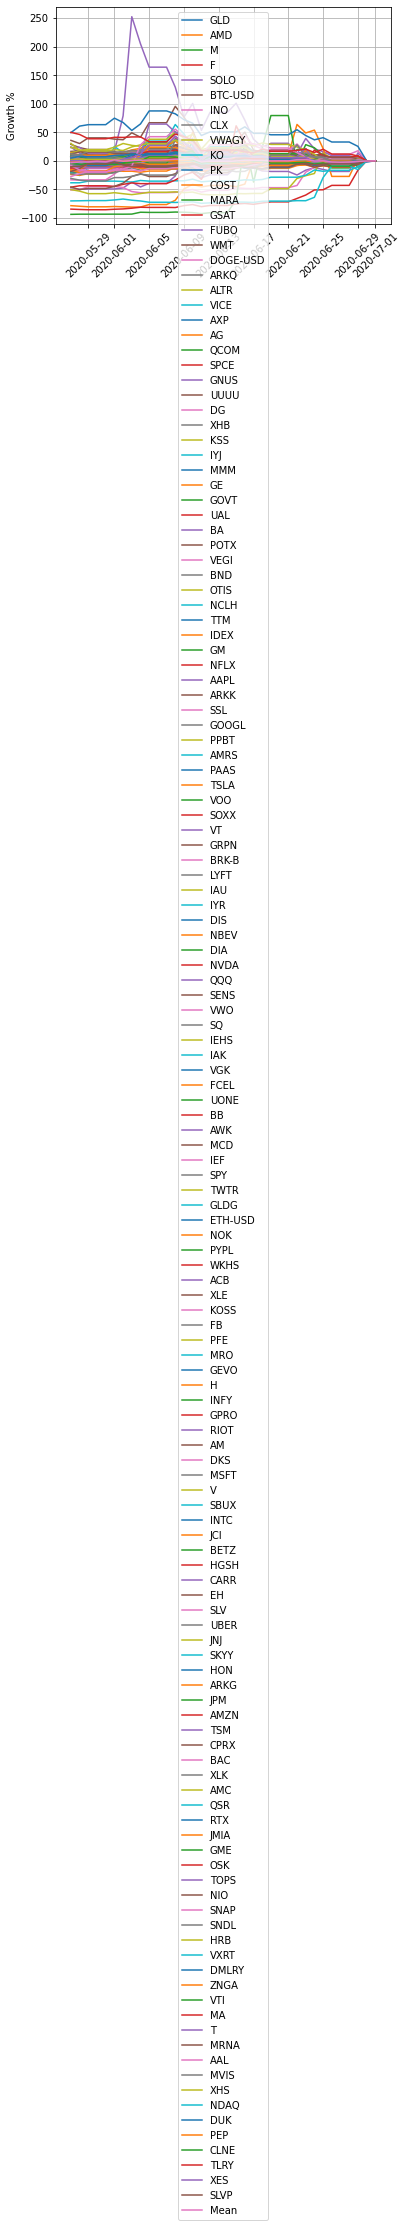

In [19]:
# Display Growth % over time
ax= plt.subplot()
for item in df_norm.columns:
    plt.plot(df_norm[item])

plt.xticks(rotation=45)
ax.legend(df.columns,loc='upper center')
plt.ylabel('Growth %')
ax.grid(True)

## How do the price gains of the listings correlate to each other?

Correlation Matrix

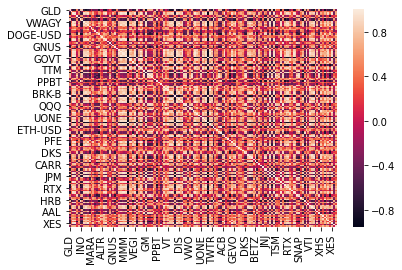

In [20]:
sns.heatmap(df_norm.corr());

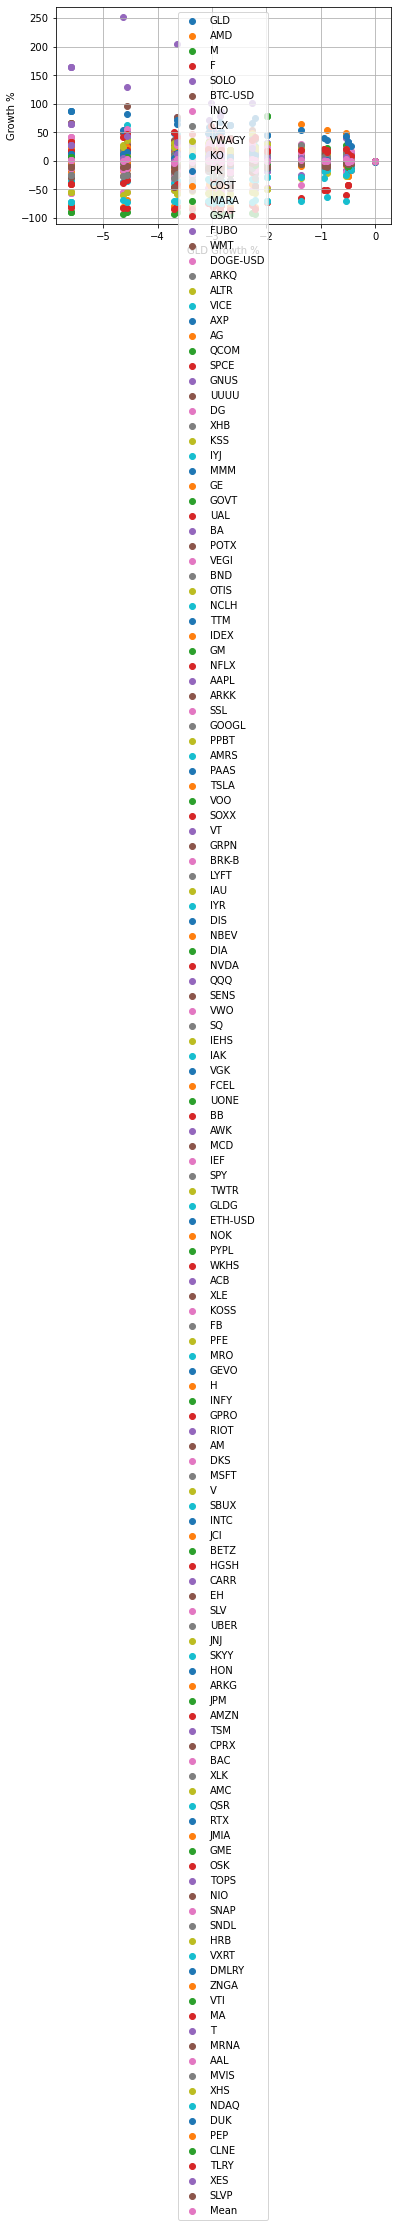

In [21]:
ax= plt.subplot()
for item in df_norm.columns:
    plt.scatter(df_norm.iloc[:,0],df_norm[item])

ax.legend(df_norm.columns,loc='upper center')
plt.xlabel('{} Growth %'.format(df_norm.columns[0]))
plt.ylabel('Growth %')
ax.grid(True)

## Calculate percent and absolute estimate and bounds of Growth 

### Create a linear regression fit for the data with thrice the standard dev. of obs.-est. to determine the boundaries

<b> Linear Regression object, score and price boundaries for each listing </b>

In [22]:
def lin_obj(df):
    df_lin=df.iloc[0:1,:]
    df_lin.reindex(['fit_obj','score','bound'])
    df_lin.drop(index=df_lin.index[0],inplace=True)
    for item in df_lin.columns:
        # ... (intercept and coeff.) of the fits
        X=np.array(pd.to_numeric(df.index)).reshape(-1, 1)
        Y=(df[item].values).reshape(-1, 1)
        lin_list_coeff=[]
        lin_list_intercept=[]
        for i in range(0,1):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0)
            lin_obj=LinearRegression()
            lin_obj.fit(X_train,y_train)
            lin_list_coeff.append(lin_obj.coef_)
            lin_list_intercept.append(lin_obj.intercept_)
        linobj = LinearRegression()
        linobj.coef_=np.array(np.array(lin_list_coeff).mean()).reshape(-1)
        linobj.intercept_=np.array(np.array(lin_list_intercept).mean()).reshape(-1)
        score=linobj.score(X,Y)
        df_lin.loc['fit_obj',item]=linobj
        df_lin.loc['score',item]=score

    # Calculate price bounds
    df_est=pd.DataFrame()
    df_est.rename_axis(index='Datetime')
    df_est['Datetime']=df.index
    df_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_lin.loc['fit_obj',item]
        for datetime in df_est.index:
            est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            df_est.loc[datetime,'{}'.format(item)]=est
    for item in df.columns:
        df_diff=df[item]-df_est[item]
        bounds=3*df_diff.std()
        df_lin.loc['bound',item]=bounds
        
    return df_lin

Convert rise and fall from % to price (using price change= percent change/100*start price) and display.<br>

In [23]:
# Call lin_obj(...) to create the price estimation object dataframe
df_norm_price_est_obj=lin_obj(df_norm)
df_price_bounds_dict={}
for item in df_norm.columns:
    df_price_bounds_dict[item]=df_norm_price_est_obj.loc['bound',item]*df_start.loc['start_price',item]/100
df_price_bounds=pd.DataFrame(df_price_bounds_dict,index=['price_bounds'])
df_norm_price_est_obj=df_norm_price_est_obj.append(df_price_bounds)
df_norm_price_est_obj

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

,GLD,AMD,M,F,SOLO,BTC-USD,INO,CLX,VWAGY,KO,PK,COST,MARA,GSAT,FUBO,WMT,DOGE-USD,ARKQ,ALTR,VICE,AXP,AG,QCOM,SPCE,GNUS,UUUU,DG,XHB,KSS,IYJ,MMM,GE,GOVT,UAL,BA,POTX,VEGI,BND,OTIS,NCLH,TTM,IDEX,GM,NFLX,AAPL,ARKK,SSL,GOOGL,PPBT,AMRS,PAAS,TSLA,VOO,SOXX,VT,GRPN,BRK-B,LYFT,IAU,IYR,DIS,NBEV,DIA,NVDA,QQQ,SENS,VWO,SQ,IEHS,IAK,VGK,FCEL,UONE,BB,AWK,MCD,IEF,SPY,TWTR,GLDG,ETH-USD,NOK,PYPL,WKHS,ACB,XLE,KOSS,FB,PFE,MRO,GEVO,H,INFY,GPRO,RIOT,AM,DKS,MSFT,V,SBUX,INTC,JCI,BETZ,HGSH,CARR,EH,SLV,UBER,JNJ,SKYY,HON,ARKG,JPM,AMZN,TSM,CPRX,BAC,XLK,AMC,QSR,RTX,JMIA,GME,OSK,TOPS,NIO,SNAP,SNDL,HRB,VXRT,DMLRY,ZNGA,VTI,MA,T,MRNA,AAL,MVIS,XHS,NDAQ,DUK,PEP,CLNE,TLRY,XES,SLVP,Mean
fit_obj,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegr

### Estimate the price and bounds vs. date using the fit object

In [24]:
# Function to estimate the price given the price dataframe, fit objects and datetime query
def price_est(df,df_norm_price_est_obj,df_strt,datetime_query):
    df_price_est=pd.DataFrame()
    df_price_est.rename_axis(index='Datetime')
    df_price_est['Datetime']=pd.to_datetime(datetime_query)
    df_price_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_norm_price_est_obj.loc['fit_obj',item]
        for datetime in df_price_est.index:
            norm_price_est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            price_est=norm_price_est*df_strt.loc['start_price',item]/100+df_strt.loc['start_price',item]
            df_price_est.loc[datetime,'{}'.format(item)]=price_est
            df_price_est.loc[datetime,'{}_low'.format(item)]=price_est-(df_norm_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_high'.format(item)]=price_est+(df_norm_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_lo_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_low'.format(item)]].mean()
            df_price_est.loc[datetime,'{}_hi_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_high'.format(item)]].mean()
            df_price_est.loc[datetime,'{}_lo_ratio'.format(item)]=df_price_est.loc[datetime,'{}_low'.format(item)]/price_est
    df_price_est.reindex(df_price_est.index.date)
    df_price_est=df_price_est
    return df_price_est


## What is the predicted share price?

In [25]:
df_price_est=price_est(df_price,df_norm_price_est_obj,df_start,datetime_query)
df_price_est.style.background_gradient(axis=1).format("{:.1f}")

,GLD,GLD_low,GLD_high,GLD_lo_mid,GLD_hi_mid,GLD_lo_ratio,AMD,AMD_low,AMD_high,AMD_lo_mid,AMD_hi_mid,AMD_lo_ratio,M,M_low,M_high,M_lo_mid,M_hi_mid,M_lo_ratio,F,F_low,F_high,F_lo_mid,F_hi_mid,F_lo_ratio,SOLO,SOLO_low,SOLO_high,SOLO_lo_mid,SOLO_hi_mid,SOLO_lo_ratio,BTC-USD,BTC-USD_low,BTC-USD_high,BTC-USD_lo_mid,BTC-USD_hi_mid,BTC-USD_lo_ratio,INO,INO_low,INO_high,INO_lo_mid,INO_hi_mid,INO_lo_ratio,CLX,CLX_low,CLX_high,CLX_lo_mid,CLX_hi_mid,CLX_lo_ratio,VWAGY,VWAGY_low,VWAGY_high,VWAGY_lo_mid,VWAGY_hi_mid,VWAGY_lo_ratio,KO,KO_low,KO_high,KO_lo_mid,KO_hi_mid,KO_lo_ratio,PK,PK_low,PK_high,PK_lo_mid,PK_hi_mid,PK_lo_ratio,COST,COST_low,COST_high,COST_lo_mid,COST_hi_mid,COST_lo_ratio,MARA,MARA_low,MARA_high,MARA_lo_mid,MARA_hi_mid,MARA_lo_ratio,GSAT,GSAT_low,GSAT_high,GSAT_lo_mid,GSAT_hi_mid,GSAT_lo_ratio,FUBO,FUBO_low,FUBO_high,FUBO_lo_mid,FUBO_hi_mid,FUBO_lo_ratio,WMT,WMT_low,WMT_high,WMT_lo_mid,WMT_hi_mid,WMT_lo_ratio,DOGE-USD,DOGE-USD_low,DOGE-USD_high,DOGE-USD_lo_mid,DOGE-USD_hi_mid,DOGE-USD_lo_ratio,ARKQ,ARKQ_low,ARKQ_high,ARKQ_lo_mid,ARKQ_hi_mid,ARKQ_lo_ratio,ALTR,ALTR_low,ALTR_high,ALTR_lo_mid,ALTR_hi_mid,ALTR_lo_ratio,VICE,VICE_low,VICE_high,VICE_lo_mid,VICE_hi_mid,VICE_lo_ratio,AXP,AXP_low,AXP_high,AXP_lo_mid,AXP_hi_mid,AXP_lo_ratio,AG,AG_low,AG_high,AG_lo_mid,AG_hi_mid,AG_lo_ratio,QCOM,QCOM_low,QCOM_high,QCOM_lo_mid,QCOM_hi_mid,QCOM_lo_ratio,SPCE,SPCE_low,SPCE_high,SPCE_lo_mid,SPCE_hi_mid,SPCE_lo_ratio,GNUS,GNUS_low,GNUS_high,GNUS_lo_mid,GNUS_hi_mid,GNUS_lo_ratio,UUUU,UUUU_low,UUUU_high,UUUU_lo_mid,UUUU_hi_mid,UUUU_lo_ratio,DG,DG_low,DG_high,DG_lo_mid,DG_hi_mid,DG_lo_ratio,XHB,XHB_low,XHB_high,XHB_lo_mid,XHB_hi_mid,XHB_lo_ratio,KSS,KSS_low,KSS_high,KSS_lo_mid,KSS_hi_mid,KSS_lo_ratio,IYJ,IYJ_low,IYJ_high,IYJ_lo_mid,IYJ_hi_mid,IYJ_lo_ratio,MMM,MMM_low,MMM_high,MMM_lo_mid,MMM_hi_mid,MMM_lo_ratio,GE,GE_low,GE_high,GE_lo_mid,GE_hi_mid,GE_lo_ratio,GOVT,GOVT_low,GOVT_high,GOVT_lo_mid,GOVT_hi_mid,GOVT_lo_ratio,UAL,UAL_low,UAL_high,UAL_lo_mid,UAL_hi_mid,UAL_lo_ratio,BA,BA_low,BA_high,BA_lo_mid,BA_hi_mid,BA_lo_ratio,POTX,POTX_low,POTX_high,POTX_lo_mid,POTX_hi_mid,POTX_lo_ratio,VEGI,VEGI_low,VEGI_high,VEGI_lo_mid,VEGI_hi_mid,VEGI_lo_ratio,BND,BND_low,BND_high,BND_lo_mid,BND_hi_mid,BND_lo_ratio,OTIS,OTIS_low,OTIS_high,OTIS_lo_mid,OTIS_hi_mid,OTIS_lo_ratio,NCLH,NCLH_low,NCLH_high,NCLH_lo_mid,NCLH_hi_mid,NCLH_lo_ratio,TTM,TTM_low,TTM_high,TTM_lo_mid,TTM_hi_mid,TTM_lo_ratio,IDEX,IDEX_low,IDEX_high,IDEX_lo_mid,IDEX_hi_mid,IDEX_lo_ratio,GM,GM_low,GM_high,GM_lo_mid,GM_hi_mid,GM_lo_ratio,NFLX,NFLX_low,NFLX_high,NFLX_lo_mid,NFLX_hi_mid,NFLX_lo_ratio,AAPL,AAPL_low,AAPL_high,AAPL_lo_mid,AAPL_hi_mid,AAPL_lo_ratio,ARKK,ARKK_low,ARKK_high,ARKK_lo_mid,ARKK_hi_mid,ARKK_lo_ratio,SSL,SSL_low,SSL_high,SSL_lo_mid,SSL_hi_mid,SSL_lo_ratio,GOOGL,GOOGL_low,GOOGL_high,GOOGL_lo_mid,GOOGL_hi_mid,GOOGL_lo_ratio,PPBT,PPBT_low,PPBT_high,PPBT_lo_mid,PPBT_hi_mid,PPBT_lo_ratio,AMRS,AMRS_low,AMRS_high,AMRS_lo_mid,AMRS_hi_mid,AMRS_lo_ratio,PAAS,PAAS_low,PAAS_high,PAAS_lo_mid,PAAS_hi_mid,PAAS_lo_ratio,TSLA,TSLA_low,TSLA_high,TSLA_lo_mid,TSLA_hi_mid,TSLA_lo_ratio,VOO,VOO_low,VOO_high,VOO_lo_mid,VOO_hi_mid,VOO_lo_ratio,SOXX,SOXX_low,SOXX_high,SOXX_lo_mid,SOXX_hi_mid,SOXX_lo_ratio,VT,VT_low,VT_high,VT_lo_mid,VT_hi_mid,VT_lo_ratio,GRPN,GRPN_low,GRPN_high,GRPN_lo_mid,GRPN_hi_mid,GRPN_lo_ratio,BRK-B,BRK-B_low,BRK-B_high,BRK-B_lo_mid,BRK-B_hi_mid,BRK-B_lo_ratio,LYFT,LYFT_low,LYFT_high,LYFT_lo_mid,LYFT_hi_mid,LYFT_lo_ratio,IAU,IAU_low,IAU_high,IAU_lo_mid,IAU_hi_mid,IAU_lo_ratio,IYR,IYR_low,IYR_high,IYR_lo_mid,IYR_hi_mid,IYR_lo_ratio,DIS,DIS_low,DIS_high,DIS_lo_mid,DIS_hi_mid,DIS_lo_ratio,NBEV,NBEV_low,NBEV_high,NBEV_lo_mid,NBEV_hi_mid,NBEV_lo_ratio,DIA,DIA_low,DIA_high,DIA_lo_mid,DIA_hi_mid,DIA_lo_ratio,NVDA,NVDA_low,NVDA_high,NVDA_lo_mid,NVDA_hi_mid,NVDA_lo_ratio,QQQ,QQQ_low,QQQ_high,QQQ_lo_mid,QQQ_hi_mid,QQQ_lo_ratio,SENS,SENS_low,SENS_high,SENS_lo_mid,SENS_hi_mid,SENS_lo_ratio,VWO,VWO_low,VWO_high,VWO_lo_mid,VWO_hi_mid,VWO_lo_ratio,SQ,SQ_low,SQ_high,SQ_lo_mid,SQ_hi_mid,SQ_lo

## What kind of volatility do the listings have?

## How do we generate our investment portfolio?

### Estimate the price history along with the bounds and plot the history and estimates for each listing

In [26]:
# Datetime history query values
datetime_query_start_end=pd.date_range(start=start,end=end)

In [27]:
# Generate and display estimates (listing, listing_low, listing_high)
df_price_est_start_end=price_est(df_price,df_norm_price_est_obj,df_start,datetime_query_start_end)
df_price_est_start_end.head().style.format("{:.0f}")

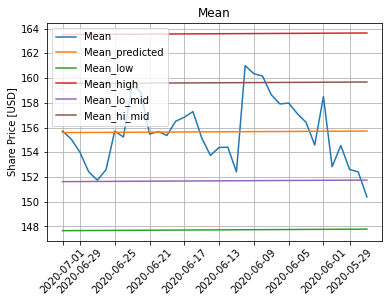

In [28]:
# Plot price vs. Time
num_plot=len(df.columns)
i=1
item = df_price.columns.tolist()[-1]
ax=plt.subplot()
plt.plot(df_price[item])
plt.plot(df_price_est_start_end[[item,item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid']])
plt.legend([item,item+'_predicted',item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid'])
plt.ylabel('Share Price [USD]')
plt.xticks(rotation=45)
if  reverse_data=='Y':
    ax.invert_xaxis()
plt.grid(True)
plt.title(item)
i=i+1

## Constructing the Portfolio

In order to balance the investments, we'd want to have the most benefit (reward) while minimizing volatility (risk).<br>
1. We can consider 'reward' to be the slope of the linear fit to share price (higher the slope, higher the gain).<br>
2. We can consider 'risk' to be the ratio between the price bounds and change in price over the duration of interest <br>
3. Hence we can compute a 'returns ratio' = 'reward'/'risk' for each listing; the higher this value, the more this investment is viable. <br>
4. Then we can compute the sum of the returns ratios for each listing and divide the returns ratio by the summed value, to determine the "weight" of each investment <br>
5. Finally we can multiply the "weight" by the total investment capital (total_investment) to obtain the recommended investment for each listing <br>    

### Use the Linear Regression object to construct the reward, volatility, returns ratio, weight and suggested investment values

In [29]:
mean_datetime=df.index.mean()
mean_price_est=price_est(df_price,df_norm_price_est_obj,df_start,[mean_datetime])

In [30]:
#Remove 'Mean' Columns
col_list=mean_price_est.columns.tolist()
for item in col_list:
    if 'Mean' in item:
        col_list.remove(item)
mean_price_est=mean_price_est.loc[:,col_list]

df_norm_price_est_obj.pop('Mean')
df.pop('Mean')
df_start.pop('Mean')

start_price    155.712261
Name: Mean, dtype: float64

In [31]:
# Initialize the portfolio dataframe df_portfolio and update the index suitably
    
df_portfolio=df_norm_price_est_obj.copy()
df_portfolio=df_portfolio.reindex(['reward','risk','returns_ratio','weight','price_bound','suggested_investment'])
df_portfolio=df_portfolio.rename_axis(index='Parameters')

# Update "reward" using the slope of the line fit (multiplied by a suitable factor for display)
for item in (df_portfolio.columns):
    df_portfolio.loc['reward',item]=(df_norm_price_est_obj.loc['fit_obj',item].coef_[0])*10**17
    
# Update the "volatility" as the line fit score
for item in (df_portfolio.columns):
    df_portfolio.loc['risk',item]=1/(df_norm_price_est_obj.loc['score',item])
                                         
# Update the returns ratio as the ratio between the "reward" and "volatility"
for item in (df_portfolio.columns):
    df_portfolio.loc['returns_ratio',item]=(df_portfolio.loc['reward',item]/
                                            df_portfolio.loc['risk',item])

    # Remove those listings with negative returns_ratio since those imply a falling stock
df_price_est_end=price_est(df,df_norm_price_est_obj,df_start,[df.index[-1].strftime('%m/%d/%y')])
for item in df_portfolio.columns:
    item_low_str=item+'_low'
    item_hi_str=item+'_high'
    if df_portfolio.loc['returns_ratio',item]<=0 or df[item].iloc[-1]>=df_price_est_end[item_hi_str].to_numpy()[0] or \
    df[item].iloc[-1]<=df_price_est_end[item_low_str].to_numpy()[0]:
        #if df_portfolio.loc['reward',item]<=201 or df_portfolio.loc['risk',item]>71:
        df_portfolio.pop(item)
        
# Obtain the weighted average of the returns ratio for each listing
for item in (df_portfolio.columns):
    df_portfolio.loc['weight',item]=df_portfolio.loc['returns_ratio',item]/df_portfolio.loc['returns_ratio',:].sum()
    
# Update stop loss limit
for item in (df_portfolio.columns):
    df_portfolio.loc['price_bound',item]=df_norm_price_est_obj.loc['price_bounds',item]
    
# Multiply the weight of each listing by the total investment capital to obtain the recommended investment
for item in (df_portfolio.columns):
    suggested_investment=df_portfolio.loc['weight',item]*total_investment
    if df_portfolio.loc['weight',item] <=0.01:
        df_portfolio.pop(item)
        
df_portfolio.loc['suggested_investment',:]=df_portfolio.loc['weight',:]*total_investment

## Sort in descending order #
df_portfolio=df_portfolio.sort_values(by='weight',axis=1,ascending=False);
if reverse_weights=='Y':
    df_portfolio.loc['weight',:]=df_portfolio.loc['weight',:][::-1].tolist()
# ## Sort in descending order #
df_portfolio.loc['suggested_investment',:]=df_portfolio.loc['weight',:]*total_investment
df_portfolio=df_portfolio.sort_values(axis=1,by='weight',ascending=False);

#Recalculate weights and suggested investments##
inv_ratio=df_portfolio.loc['suggested_investment'].sum()/total_investment;
for item in (df_portfolio.columns):
    df_portfolio.loc['weight',item]=df_portfolio.loc['weight',item]/inv_ratio
    suggested_investment=df_portfolio.loc['weight',item]*total_investment
    df_portfolio.loc['suggested_investment',item]=suggested_investment


# Display the portfolio dataframe
df_portfolio

,UONE,IDEX,HGSH,WKHS,NIO,PPBT,INO,MVIS,SOLO,VXRT,SQ,SNAP,GLDG,TSLA,KOSS,AAPL,AMZN,PYPL,DKS,MSFT,ARKK,TSM
Parameters,,,,,,,,,,,,,,,,,,,,,,
reward,5052.348066,3935.394202,2295.264074,2075.452517,1542.164114,2112.862033,2032.009225,1512.91445,1564.19652,1857.284978,829.063117,810.881995,949.90992,619.270836,1033.508985,455.670848,433.855217,445.346776,464.330855,337.642826,402.557688,369.831858
risk,1.69864,1.477118,1.636351,1.48432,1.208372,1.666231,1.788427,1.386633,1.518984,2.152117,1.137679,1.134065,1.447738,1.334633,2.516325,1.114315,1.106062,1.191841,1.263112,1.163263,1.444567,1.439547
returns_ratio,2974.348149,2664.238395,1402.672024,1398.251486,1276.233232,1268.048962,1136.198847,1091.070945,1029.765286,863.003521,728.731938,715.022254,656.133855,464.000682,410.721512,408.924714,392.252101,373.662822,367.608524,290.254957,278.670206,256.908509
weight,0.145468,0.130301,0.068601,0.068385,0.062417,0.062017,0.055569,0.053362,0.050363,0.042207,0.035641,0.03497,0.03209,0.022693,0.020087,0.02,0.019184,0.018275,0.017979,0.014196,0.013629,0.012565
price_bound,23.352944,1.492085,0.800014,6.859224,1.484102,5.227607,13.278891,0.349381,0.692384,4.817999,8.815749,1.904564,0.302023,21.127064,0.472657,3.800088,106.449832,9.280871,2.505142,7.481251,5.102459,3.706707
suggested_investment,1018.422926,912.240709,480.277787,478.764186,436.984885,434.182574,389.036823,373.584937,352.593753,295.494181,249.519315,244.825091,224.661582,158.874788,140.631891,140.016664,134.307926,127.942919,125.869915,99.383895,95.417252,87.966002


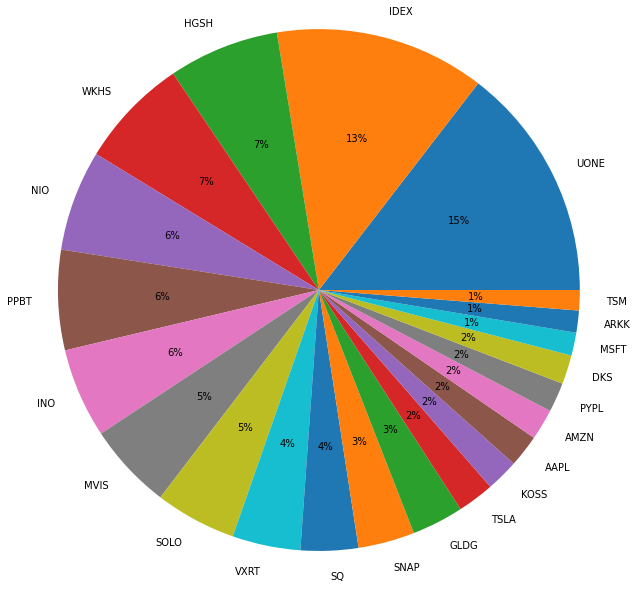

In [32]:
stock_labels=df_portfolio.columns
values=df_portfolio.loc['suggested_investment',:]
plt.pie(values, labels=stock_labels,radius=3, autopct='%1.0f%%');

## Save Portfolio Data

In [33]:
if save_port=='Y' or save_port==True:
    df_portfolio.sort_values(axis=1,by='weight',ascending=False).to_csv('portfolio.csv')
if save_mean=='Y' or save_mean==True:
    df_price.loc[:,'Mean'].to_csv('mean.csv')

## Weighted Mean

### Portfolio Weighted Mean

In [34]:
df_port_weights=df_portfolio.loc['weight',:]

weight_stocks=df_port_weights.index.tolist()
port_data=df_price.loc[:,weight_stocks]

port_weight_data=port_data.copy()
for ticker in port_weight_data.columns:
    port_weight_data.loc[:,ticker]=port_weight_data.loc[:,ticker]*df_port_weights[ticker]
port_weighted_mean_data=port_weight_data.sum(axis=1)
df_port_price_means=df_price.loc[:,'Mean']
df_port_price_means['Weighted_Mean']=port_weighted_mean_data

Text(0.5, 1.0, 'Portfolio Weighted_Mean')

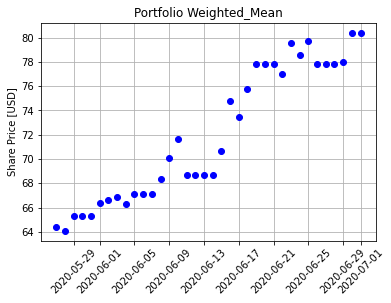

In [35]:
## Plot Weighted Mean ##
plt.figure()
plt.plot(df_port_price_means['Weighted_Mean'],'bo')
plt.ylabel('Share Price [USD]')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Portfolio Weighted_Mean')

### Saved Portfolio Weighted Mean (read data from 'portfolio.csv')

In [36]:
df_port_weights=pd.read_csv('portfolio.csv')
df_port_weights.set_index('Parameters',inplace=True)

weight_stocks=df_port_weights.columns.tolist()
port_data=df_price.loc[:,weight_stocks]

avg_weights=df_port_weights.loc['weight',:]
weight_data=port_data.copy()

for ticker in weight_data.columns:
    weight_data.loc[:,ticker]=weight_data.loc[:,ticker]*avg_weights.loc[ticker]
weighted_mean_data=weight_data.sum(axis=1)
df_price_means=df_price.loc[:,'Mean']
df_price_means['Weighted_Mean']=weighted_mean_data

In [37]:
weight_data.tail()

,FCEL,TSLA,MRNA,NVDA,AMD,AAPL,INO,MSFT,PAAS,SPCE,GLDG,CARR,CLX,ZNGA,IAU,GLD,DG,TSM,VXRT,INTC,ARKQ,ARKG,NFLX,AMZN,ARKK,QQQ,XLK,IEF,SOXX,GOVT,NIO
2020-05-31,0.212369,13.245728,4.057559,5.655390,3.191787,3.164476,0.570367,5.676796,0.886161,0.450614,0.026187,0.451227,4.307087,0.195198,0.698897,3.406756,3.925909,1.001967,0.055088,1.165988,0.785676,0.800954,6.778324,39.291440,0.902941,3.378208,1.408078,1.561512,3.041025,0.306870,0.044054
2020-05-30,0.212369,13.245728,4.057559,5.655390,3.191787,3.164476,0.570367,5.676796,0.886161,0.450614,0.026187,0.451227,4.307087,0.195198,0.698897,3.406756,3.925909,1.001967,0.055088,1.165988,0.785676,0.800954,6.778324,39.291440,0.902941,3.378208,1.408078,1.561512,3.041025,0.306870,0.044054
2020-05-29,0.212369,13.245728,4.057559,5.655390,3.191787,3.164476,0.570367,5.676796,0.886161,0.450614,0.026187,0.451227,4.307087,0.195198,0.698897,3.406756,3.925909,1.001967,0.055088,1.165988,0.785676,0.800954,6.778324,39.291440,0.902941,3.378208,1.408078,1.561512,3.041025,0.306870,0.044054
2020-05-28,0.210375,12.782683,3.664338,5.407842,3.069574,3.167561,0.516230,5.619486,0.814481,0.435540,0.025018,0.432049,4.280149,0.172158,0.694246,3.381871,3.774211,1.000972,0.054472,1.143198,0.774467,0.782806,6.676745,38.627512,0.887562,3.329423,1.390543,1.556517,2.965078,0.306212,0.042393
2020-05-27,0.216357,13.011430,3.442657,5.432214,3.128901,3.166168,0.510043,5.632187,0.789983,0.463307,0.025018,0.440646,4.176570,0.170451,0.692555,3.370578,3.837555,1.030037,0.054061,1.177661,0.787427,0.797670,6.780908,38.776960,0.898486,3.333766,1.393274,1.557926,3.031245,0.306431,0.046157


Text(0.5, 1.0, 'Saved Portfolio Weighted_Mean')

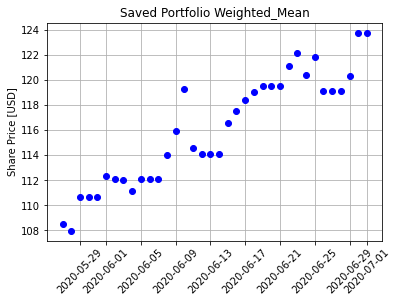

In [38]:
## Plot Weighted Mean ##
plt.figure()
plt.plot(df_price_means['Weighted_Mean'],'bo')
plt.ylabel('Share Price [USD]')
if reverse_data=='Y':
    ax.invert_xaxis()
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Saved Portfolio Weighted_Mean')

## Compare with previous

In [39]:
df_saved=pd.read_csv('portfolio.csv')
df_saved.set_index('Parameters',inplace=True)

In [40]:
comm_stocks=list(set(df_saved.columns.tolist()).intersection(set(df_portfolio.columns.tolist())))

Sum: weight_diff   -336.14857
dtype: float64, Min.: weight_diff   -249.513903
dtype: float64, Max.: weight_diff    82.266634
dtype: float64


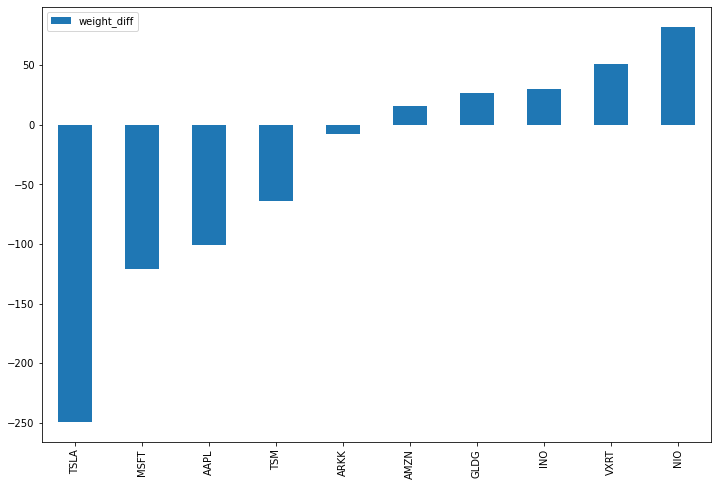

In [41]:
weight_diff={}
for i in range(len(comm_stocks)):
    ticker=comm_stocks[i]
    weight_diff[ticker]=(df_portfolio.loc['weight',
                                          ticker]-df_saved.loc['weight',ticker])/df_portfolio.loc['weight',ticker]*100
df_weight_diff=pd.DataFrame(weight_diff,index=['weight_diff'])
print('Sum: {}, Min.: {}, Max.: {}'.format(df_weight_diff.sum(axis=1),df_weight_diff.min(axis=1),df_weight_diff.max(axis=1)))
df_weight_diff.sort_values(axis=1,by='weight_diff').transpose().plot(kind='bar',figsize=(12,8));

## Lowest Trending

In [42]:
# Initialize the portfolio dataframe df_portfolio and update the index suitably
df_down=df_norm_price_est_obj
df_down=df_down.reindex(['reward','risk','returns_ratio','weight','price_bound'])
df_down=df_down.rename_axis(index='Parameters')

# Update "reward" using the slope of the line fit (multiplied by a suitable factor for display)
for item in (df_down.columns):
    df_down.loc['reward',item]=(df_norm_price_est_obj.loc['fit_obj',item].coef_[0])*10**17
    
# Update the "volatility" as the line fit score
for item in (df_down.columns):
    df_down.loc['risk',item]=1/(df_norm_price_est_obj.loc['score',item])
                                         
# Update the returns ratio as the ratio between the "reward" and "volatility"
for item in (df_down.columns):
    df_down.loc['returns_ratio',item]=(df_down.loc['reward',item]/
                                            df_down.loc['risk',item])
    
# Remove those listings with negative returns_ratio since those imply a falling stock
df_price_est_end=price_est(df,df_norm_price_est_obj,df_start,[df.index[-1].strftime('%m/%d/%y')])
for item in df_down.columns:
    item_low_str=item+'_low'
    item_hi_str=item+'_high'
    if df_down.loc['returns_ratio',item]>=-21 or df[item].iloc[-1]>=df_price_est_end[item_hi_str].to_numpy()[0]:
        if df_down.loc['reward',item]>=-201:
            df_down.pop(item)
        
# Obtain the weighted average of the returns ratio for each listing
for item in (df_down.columns):
    df_down.loc['weight',item]=df_down.loc['returns_ratio',item]/df_down.loc['returns_ratio',:].sum()
    
# Update stop loss limit
for item in (df_down.columns):
    df_down.loc['price_bound',item]=df_norm_price_est_obj.loc['price_bounds',item]
    
# Display the portfolio dataframe
df_down.sort_values(axis=1,by='weight',ascending=False).style.background_gradient(axis=1).format("{:.2f}")

,TLRY,GEVO,GRPN,HRB,PFE,UBER,SENS,UUUU,ACB,H,AMC,DOGE-USD,POTX,DUK,GNUS,INTC,SBUX,JNJ,DIS,GM,BETZ,EH,T,RTX,BRK-B,JPM,KO,XHS,WMT,HON,COST,IEHS,XLE,FUBO,BTC-USD,AG,PK,OSK,BAC,SPCE,M,TWTR,MCD,VICE,MA,AXP,NCLH,VWAGY,QSR,GE,MMM,XES,KSS,TOPS,FCEL
Parameters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
reward,-1385.42,-1697.37,-1761.84,-1010.83,-628.91,-758.51,-759.61,-555.68,-607.00,-732.28,-914.06,-378.60,-472.09,-388.68,-2253.44,-309.69,-347.46,-232.28,-341.34,-433.96,-302.10,-363.97,-265.48,-372.01,-294.74,-363.81,-237.43,-224.69,-140.78,-270.06,-133.61,-163.45,-321.01,-320.21,-176.82,-272.32,-498.31,-297.73,-301.64,-258.97,-466.97,-306.83,-162.61,-138.76,-132.21,-231.43,-469.73,-174.52,-149.63,-246.88,-130.36,-318.53,-329.20,-366.01,-236.36
risk,1.21,1.74,2.17,1.70,1.16,1.41,1.76,1.30,1.56,2.17,3.10,1.36,2.02,1.83,10.74,1.55,1.87,1.36,2.02,3.33,2.42,3.00,2.22,3.15,2.53,3.40,2.39,2.39,1.82,3.54,1.80,2.48,4.88,5.00,2.79,4.76,8.89,5.43,5.50,4.89,8.97,6.05,3.99,3.55,3.65,7.57,15.61,6.51,6.15,10.23,5.97,15.53,16.76,40.56,31.58
returns_ratio,-1149.25,-974.89,-812.99,-593.25,-542.51,-536.94,-430.47,-427.72,-388.60,-337.65,-294.90,-277.49,-234.26,-212.86,-209.77,-199.73,-186.04,-170.48,-169.05,-130.49,-124.81,-121.18,-119.41,-118.03,-116.46,-107.03,-99.15,-93.98,-77.18,-76.38,-74.13,-65.81,-65.80,-63.99,-63.40,-57.18,-56.03,-54.88,-54.84,-53.01,-52.03,-50.69,-40.78,-39.05,-36.26,-30.59,-30.10,-26.82,-24.33,-24.14,-21.82,-20.51,-19.65,-9.02,-7.48
weight,0.11,0.09,0.08,0.06,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
price_bound,1.22,0.32,9.42,3.06,1.99,4.14,0.07,0.13,1.54,10.87,1.55,0.00,1.26,7.26,4.32,3.61,6.33,5.17,10.49,4.57,1.48,1.47,2.13,8.84,17.78,13.77,3.26,4.91,4.08,16.52,9.53,1.66,6.06,1.83,596.02,1.43,3.78,12.01,4.02,2.28,2.45,5.61,13.68,1.36,17.22,15.07,8.06,1.72,4.81,11.13,11.79,10.75,7.28,2.20,0.81


## View Specific Stock(s)

(                            TSLA
 Parameters                      
 reward                619.270836
 risk                    1.334633
 returns_ratio         464.000682
 weight                  0.022693
 price_bound            21.127064
 suggested_investment  158.874788,
                  DOGE-USD
 Parameters               
 reward        -378.597456
 risk             1.364376
 returns_ratio -277.487679
 weight           0.026745
 price_bound      0.000147)

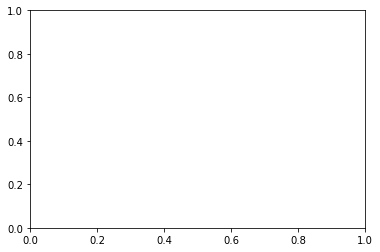

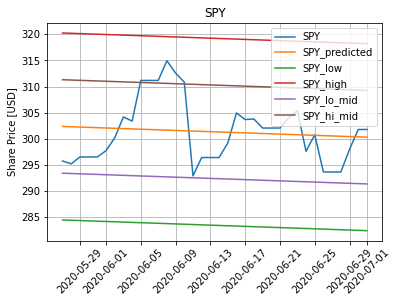

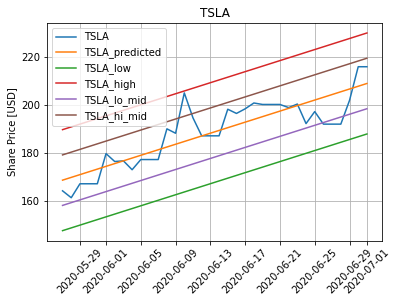

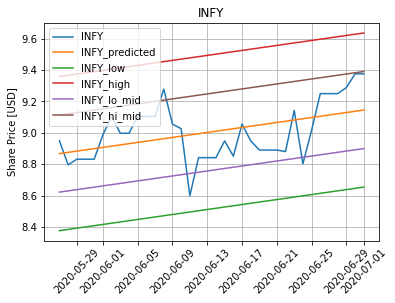

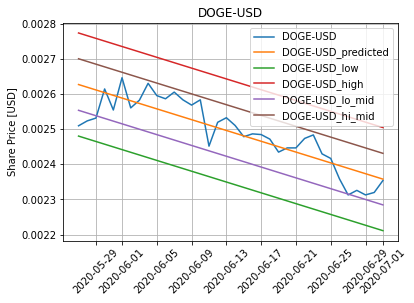

In [43]:
# Plot Specific price vs. Time
plot_list=['SPY','TSLA','INFY','RBLX','DOGE-USD']
num_plot=len(plot_list)
i=1
for item in list(set(plot_list).intersection(df_price.columns.tolist())):
    ax=plt.subplot();
    plt.figure()
    plt.plot(df_price[item])
    plt.plot(df_price_est_start_end[[item,item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid']])
    plt.legend([item,item+'_predicted',item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid'])
    plt.ylabel('Share Price [USD]')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(item)
    i=i+1
#View specific stock values
df_portfolio.loc[:,
                 list(set(plot_list).intersection(df_portfolio.columns.tolist()))],df_down.loc[:,
                                                                                                    list(set(plot_list).intersection(df_down.columns.tolist()))]